In [1]:
import pandas as pd
import numpy as np
import pymc as pm
from src.data_utils import load_and_process_data
from src.model import run_full_analysis, build_and_sample_model
from src.trace_save_load import load_previous_season_trace, extract_previous_season_priors, save_season_trace
import matplotlib.pyplot as plt

league = ['Premier_League']
season = '2025-2026'



In [2]:
# Simple one-liner to get everything ready
df, team_mapping, n_teams = load_and_process_data(
    db_path=r'/Users/admin/Documents/dev/algobetting/infra/data/db/fotmob.db',
    league=league, 
    season=season,
    max_goals=9,
    decay_rate=0.002,
    goals_weight=0.18,
    xg_weight=0.45,
    psxg_weight=0.27,
    epv_weight=0.1

)

df.head()

,match_id,league_id,match_date,home_team,away_team,home_goals,away_goals,weight,days_ago,is_actual,poisson_binomial_xg_prob,poisson_binomial_psxg_prob,poisson_xg_total_prob,poisson_epv_prob,home_idx,away_idx
0,4813387,Premier_League,2025-08-23,Brentford,Aston Villa,0,0,0.040911,43,False,0.041091,0.009872,0.070632,0.118963,3,1
1,4813387,Premier_League,2025-08-23,Brentford,Aston Villa,0,1,0.047940,43,False,0.055174,0.001421,0.084199,0.160362,3,1
2,4813387,Premier_League,2025-08-23,Brentford,Aston Villa,0,2,0.029485,43,False,0.033405,0.000040,0.050185,0.108084,3,1
3,4813387,Premier_League,2025-08-23,Brentford,Aston Villa,0,3,0.012208,43,False,0.012132,0.000000,0.019942,0.048566,3,1
4,4813387,Premier_League,2025-08-23,Brentford,Aston Villa,0,4,0.003805,43,False,0.002964,0.000000,0.005943,0.016367,3,1


In [3]:
goals = df[df['is_actual'] == True]

average_goasl = (goals['home_goals'] + goals['away_goals'])
average_goasl.mean()

np.float64(2.6)

In [4]:
df[df["match_id"] == 4813428]["weight"].sum()

np.float64(0.9841273200552847)

In [5]:
# manual priors

# Attack strength priors (mu, sigma)
# Using sigma=0.1 for tighter priors based on historical data
manual_att_priors = {
    'Arsenal': (0.198, 0.25),
    'Aston Villa': (0.121, 0.25),
    'Bournemouth': (0.100, 0.25),
    'Brentford': (0.079, 0.25),
    'Brighton': (0.083, 0.25),
    'Chelsea': (0.185, 0.25),
    'Crystal Palace': (0.057, 0.25),
    'Everton': (-0.108, 0.25),
    'Fulham': (-0.030, 0.25),
    'Liverpool': (0.371, 0.25),
    'Man City': (0.297, 0.25),
    'Man United': (0.011, 0.25),
    'Newcastle': (0.207, 0.25),
    'Nottm Forest': (-0.003, 0.25),
    'Tottenham': (0.121, 0.25),
    'West Ham': (-0.082, 0.25),
    'Wolves': (-0.094, 0.25),

    'Burnley': (-0.401, 0.3),
    'Leeds': (-0.103, 0.3),
    'Sunderland': (-0.553, 0.3)
}

# Defense strength priors (mu, sigma)
# Using sigma=0.1 for tighter priors based on historical data
manual_def_priors = {
    'Arsenal': (-0.340, 0.25),
    'Aston Villa': (-0.085, 0.25),
    'Bournemouth': (-0.001, 0.25),
    'Brentford': (-0.054, 0.25),
    'Brighton': (0.107, 0.25),
    'Chelsea': (-0.166, 0.25),
    'Crystal Palace': (0.052, 0.25),
    'Everton': (-0.085, 0.25),
    'Fulham': (-0.014, 0.25),
    'Liverpool': (-0.222, 0.25),
    'Man City': (-0.191, 0.25),
    'Man United': (-0.035, 0.25),
    'Newcastle': (-0.083, 0.25),
    'Nottm Forest': (-0.046, 0.25),
    'Tottenham': (0.163, 0.25),
    'West Ham': (0.103, 0.25),
    'Wolves': (0.137, 0.25),

    'Burnley': (0.163, 0.3),
    'Leeds': (0.163, 0.3),
    'Sunderland': (0.231, 0.3)
}



In [6]:
model, trace = build_and_sample_model(
     df, 
     n_teams, 
     team_mapping=team_mapping,
     trace=10000,
     tune=5000,
     manual_att_priors=manual_att_priors,
     manual_def_priors=manual_def_priors
 )

                  mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  r_hat
att_str_raw[0]   0.254  0.194  -0.138    0.602      0.002    0.003    8051.0    3331.0    1.0
att_str_raw[1]  -0.007  0.205  -0.402    0.372      0.003    0.003    6265.0    2988.0    1.0
att_str_raw[2]   0.069  0.194  -0.305    0.418      0.002    0.003    6342.0    3384.0    1.0
att_str_raw[3]   0.071  0.205  -0.315    0.439      0.003    0.003    6410.0    3021.0    1.0
att_str_raw[4]   0.142  0.210  -0.259    0.529      0.003    0.004    6066.0    2963.0    1.0
att_str_raw[5]  -0.360  0.233  -0.779    0.092      0.003    0.004    6008.0    3127.0    1.0
att_str_raw[6]   0.281  0.208  -0.101    0.680      0.003    0.004    6445.0    2997.0    1.0
att_str_raw[7]   0.125  0.201  -0.238    0.502      0.003    0.003    5792.0    2956.0    1.0
att_str_raw[8]  -0.077  0.206  -0.438    0.337      0.003    0.003    6525.0    2935.0    1.0
att_str_raw[9]  -0.032  0.207  -0.437    0.333      0.003   

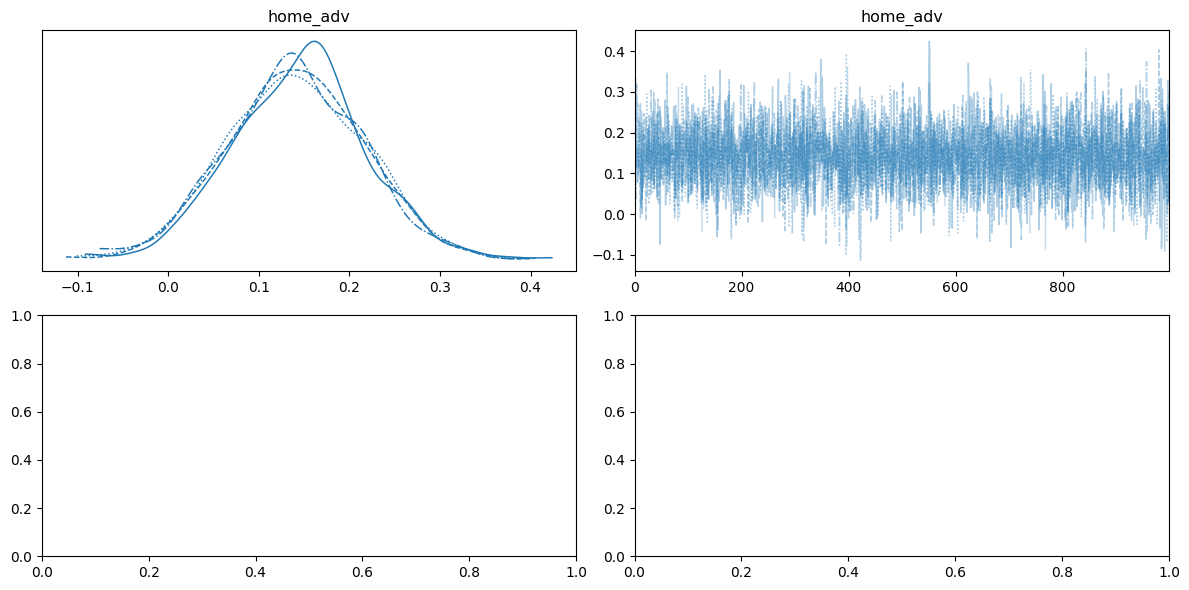

In [7]:
import arviz as az
import matplotlib.pyplot as plt
import pandas as pd

# Quick summary - full table display with 2 decimal places
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)
pd.set_option('display.expand_frame_repr', False)  # Prevents wrapping
pd.set_option('display.precision', 3)  # 2 decimal places

summary = az.summary(trace)
print(summary)

# Quick plots
fig, axes = plt.subplots(2, 2, figsize=(12, 6))

# Trace plots for key parameters
az.plot_trace(trace, var_names=['home_adv'], axes=axes)
plt.tight_layout()
plt.show()


In [8]:
# Manually calculate what the "vs average" SHOULD give
# for the exact same 10 matches in your weekly predictions

matches = [
    ('Brighton', 'Newcastle'),
    ('Burnley', 'Leeds'),
    ('Crystal Palace', 'Bournemouth'),
    ('Fulham', 'Arsenal'),
    ('Liverpool', 'Man United'),
    ('Man City', 'Everton'),
    ('Nottm Forest', 'Chelsea'),
    ('Sunderland', 'Wolves'),
    ('Tottenham', 'Aston Villa'),
    ('West Ham', 'Brentford')
]

# Get the summary stats
baseline_mean = summary.loc['baseline', 'mean']
home_adv_mean = summary.loc['home_adv', 'mean']

total_from_teams = 0

for home, away in matches:
    home_idx = team_mapping[home]
    away_idx = team_mapping[away]
    
    att_home = summary.loc[f'att_str[{home_idx}]', 'mean']
    def_home = summary.loc[f'def_str[{home_idx}]', 'mean']
    att_away = summary.loc[f'att_str[{away_idx}]', 'mean']
    def_away = summary.loc[f'def_str[{away_idx}]', 'mean']
    
    # Calculate as if each team plays 50% home / 50% away
    home_team_contribution = (np.exp(baseline_mean + home_adv_mean + att_home + def_away) + 
                              np.exp(baseline_mean + att_home + def_away)) / 2
    away_team_contribution = (np.exp(baseline_mean + home_adv_mean + att_away + def_home) + 
                              np.exp(baseline_mean + att_away + def_home)) / 2
    
    total_from_teams += home_team_contribution + away_team_contribution

print(f"Total goals if each team in these fixtures played 50/50 home/away: {total_from_teams:.2f}")
print(f"Your 'vs average' for all 20 teams: {27.51:.2f}")
print(f"Your actual weekly predictions: {29.87:.2f}")

Total goals if each team in these fixtures played 50/50 home/away: 27.77
Your 'vs average' for all 20 teams: 27.51
Your actual weekly predictions: 29.87


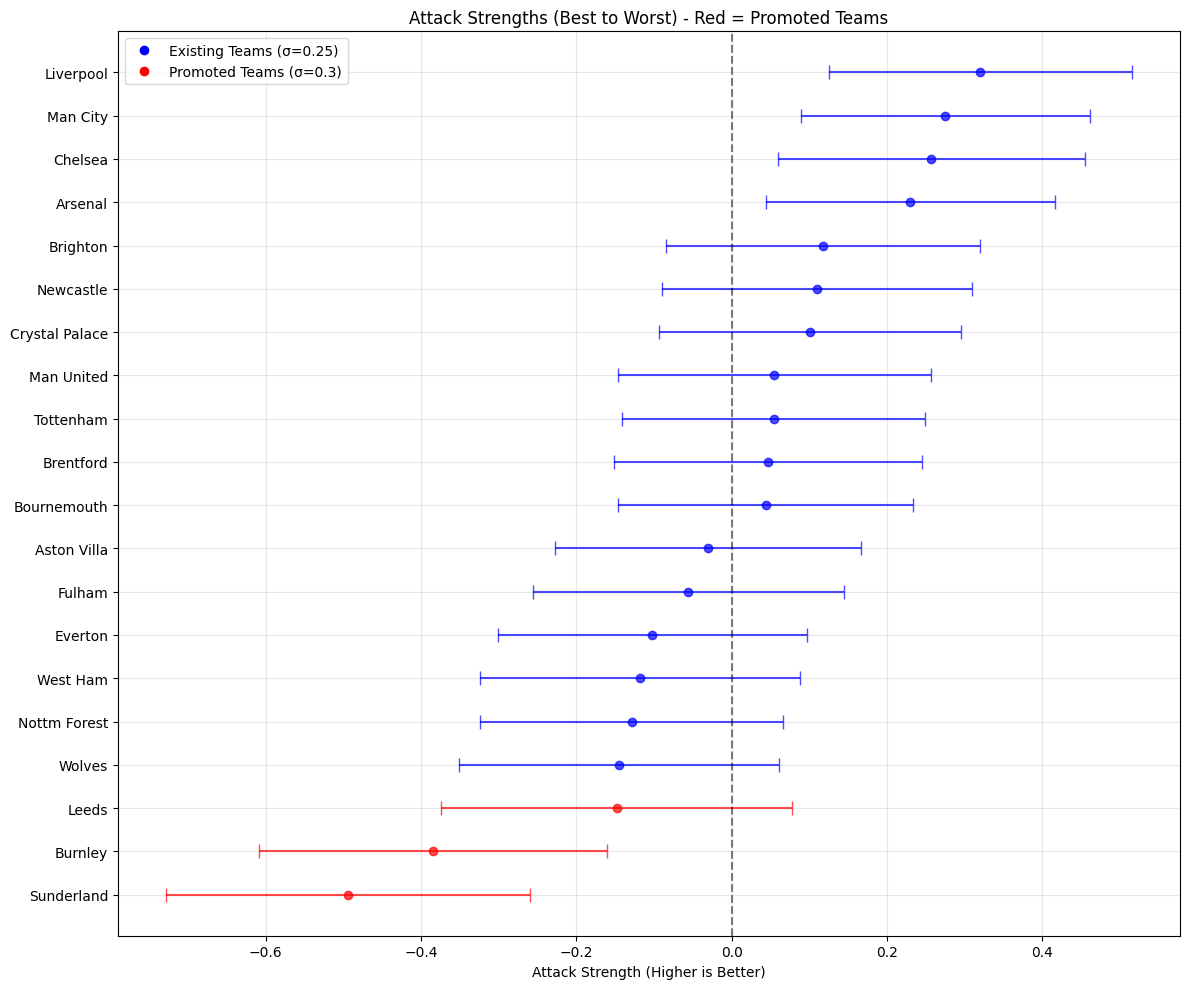

In [9]:
# Extract attack data
att_means = []
att_stds = []
att_team_names = []

for i in range(20):
    team_name = [k for k, v in team_mapping.items() if v == i][0]
    att_means.append(summary.loc[f'att_str[{i}]', 'mean'])
    att_stds.append(summary.loc[f'att_str[{i}]', 'sd'])
    att_team_names.append(team_name)

# Create DataFrame and sort by attack strength (higher is better attack)
att_data = list(zip(att_means, att_stds, att_team_names))
att_data_sorted = sorted(att_data, key=lambda x: x[0], reverse=True)  # Sort by mean (descending)

# Extract sorted data
sorted_att_means = [x[0] for x in att_data_sorted]
sorted_att_stds = [x[1] for x in att_data_sorted]
sorted_att_names = [x[2] for x in att_data_sorted]

# Create attack plot (best to worst)
fig, ax = plt.subplots(figsize=(12, 10))

promoted_teams = ['Burnley', 'Leeds', 'Sunderland']

for i, (mean, std, name) in enumerate(zip(sorted_att_means, sorted_att_stds, sorted_att_names)):
    color = 'red' if name in promoted_teams else 'blue'
    # Flip the y-position so best is at top
    ax.errorbar(mean, len(sorted_att_names)-1-i, xerr=std, fmt='o', capsize=5, 
                color=color, ecolor=color, alpha=0.7)

ax.set_yticks(range(len(sorted_att_names)))
ax.set_yticklabels(reversed(sorted_att_names))  # Reverse the labels to match
ax.set_xlabel('Attack Strength (Higher is Better)')
ax.set_title('Attack Strengths (Best to Worst) - Red = Promoted Teams')
ax.grid(True, alpha=0.3)
ax.axvline(x=0, color='black', linestyle='--', alpha=0.5)

# Add legend
from matplotlib.lines import Line2D
legend_elements = [Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', 
                         markersize=8, label='Existing Teams (σ=0.25)'),
                  Line2D([0], [0], marker='o', color='w', markerfacecolor='red', 
                         markersize=8, label='Promoted Teams (σ=0.3)')]
ax.legend(handles=legend_elements)

plt.tight_layout()
plt.show()

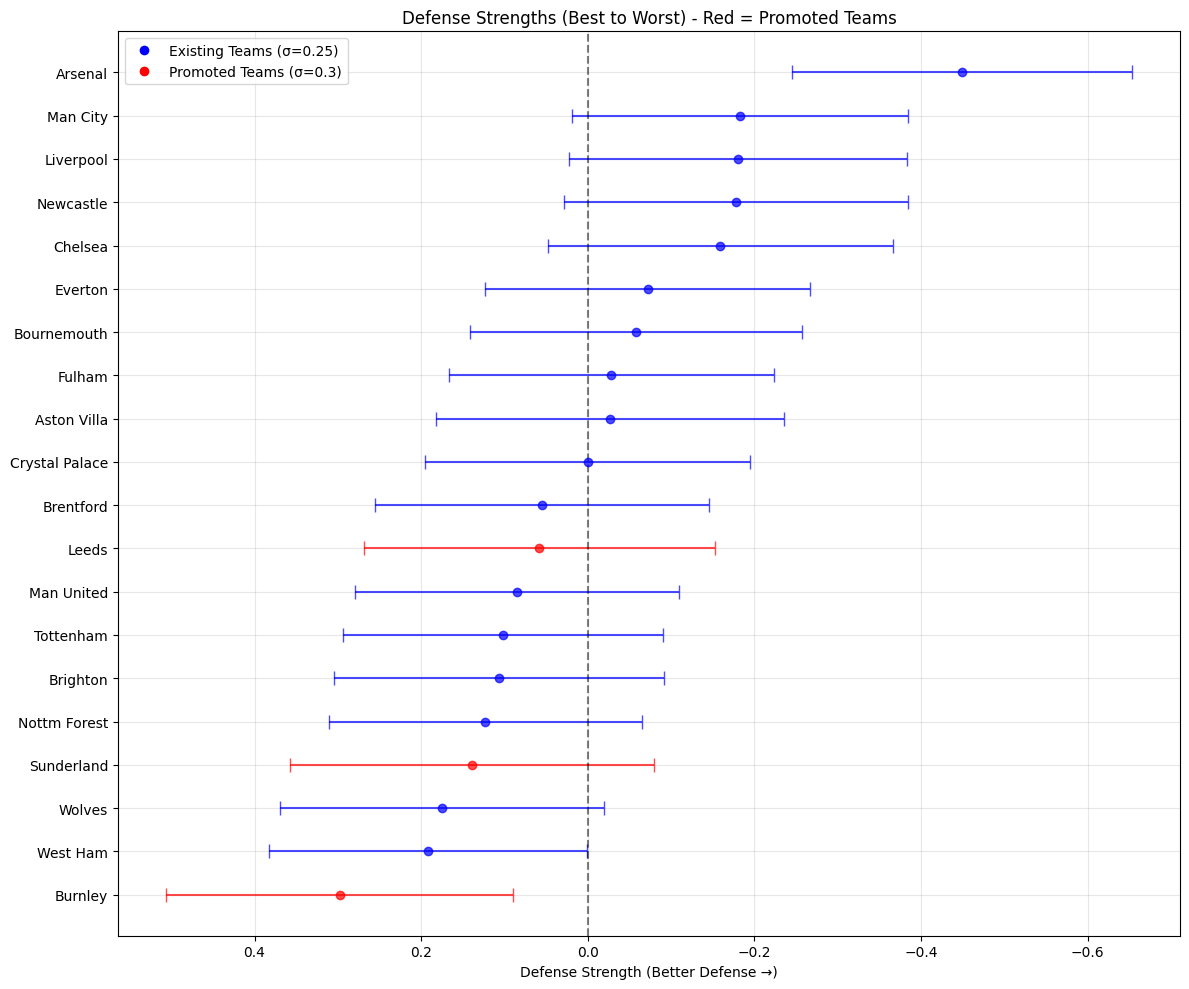

In [10]:
# Extract defense data
def_means = []
def_stds = []
def_team_names = []

for i in range(20):
    team_name = [k for k, v in team_mapping.items() if v == i][0]
    def_means.append(summary.loc[f'def_str[{i}]', 'mean'])
    def_stds.append(summary.loc[f'def_str[{i}]', 'sd'])
    def_team_names.append(team_name)

# Create DataFrame and sort by defense strength (lower is better defense)
def_data = list(zip(def_means, def_stds, def_team_names))
def_data_sorted = sorted(def_data, key=lambda x: x[0])  # Sort by mean (ascending)

# Extract sorted data
sorted_def_means = [x[0] for x in def_data_sorted]
sorted_def_stds = [x[1] for x in def_data_sorted]
sorted_def_names = [x[2] for x in def_data_sorted]

# Create defense plot (best to worst)
fig, ax = plt.subplots(figsize=(12, 10))
y_pos = np.arange(len(sorted_def_names))

promoted_teams = ['Burnley', 'Leeds', 'Sunderland']

for i, (mean, std, name) in enumerate(zip(sorted_def_means, sorted_def_stds, sorted_def_names)):
    color = 'red' if name in promoted_teams else 'blue'
    # Reverse y-position so best defense is at top
    ax.errorbar(mean, len(sorted_def_names)-1-i, xerr=std, fmt='o', capsize=5, 
                color=color, ecolor=color, alpha=0.7)

ax.set_yticks(range(len(sorted_def_names)))
ax.set_yticklabels(reversed(sorted_def_names))  # Reverse labels to match reversed positions
ax.set_xlabel('Defense Strength (Better Defense →)')
ax.set_title('Defense Strengths (Best to Worst) - Red = Promoted Teams')
ax.grid(True, alpha=0.3)
ax.axvline(x=0, color='black', linestyle='--', alpha=0.5)
ax.invert_xaxis()  # Flip x-axis so negative is to the right

# Add legend
from matplotlib.lines import Line2D
legend_elements = [Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', 
                         markersize=8, label='Existing Teams (σ=0.25)'),
                  Line2D([0], [0], marker='o', color='w', markerfacecolor='red', 
                         markersize=8, label='Promoted Teams (σ=0.3)')]
ax.legend(handles=legend_elements)

plt.tight_layout()
plt.show()

In [11]:
# Team ratings vs average team (0 rating)
import numpy as np

# Get baseline and home advantage from trace
baseline_mean = summary.loc['baseline', 'mean']
home_adv_mean = summary.loc['home_adv', 'mean']

print("=== TEAM RATINGS VS AVERAGE TEAM ===")
print(f"Baseline (neutral venue): {baseline_mean:.3f}")
print(f"Home advantage: {home_adv_mean:.3f}")
print()

# Calculate goals for/against vs average team (0,0 ratings)
team_ratings = []

for team, idx in team_mapping.items():
    att_strength = summary.loc[f'att_str[{idx}]', 'mean']
    def_strength = summary.loc[f'def_str[{idx}]', 'mean']
    
    # Goals scored vs average team at home
    goals_for = np.exp(baseline_mean + att_strength + 0 )  # vs avg def (0)

    
    # Goals conceded vs average team away
    goals_against = np.exp(baseline_mean + 0 + def_strength)  # avg att (0) with home adv
    
    goal_difference = goals_for - goals_against
    
    team_ratings.append({
        'team': team,
        'goals_for': goals_for,
        'goals_against': goals_against,
        'goal_diff_vs_avg': goal_difference,
    })

# Convert to DataFrame and sort by goal difference
ratings_df = pd.DataFrame(team_ratings)
ratings_df = ratings_df.sort_values('goal_diff_vs_avg', ascending=False)

print(f'Total Goals For: {ratings_df['goals_for'].sum():.2f}')
print(f'Total Goals Against: {ratings_df['goals_against'].sum():.2f}')
print()

# Display main table
print("TEAM RATINGS vs AVERAGE TEAM (sorted by goal difference):")
print("=" * 80)
display_df = ratings_df[['team', 'goals_for', 'goals_against', 'goal_diff_vs_avg']].copy()

pd.set_option('display.float_format', '{:.2f}'.format)
print(display_df.to_string(index=False))

=== TEAM RATINGS VS AVERAGE TEAM ===
Baseline (neutral venue): 0.226
Home advantage: 0.142

Total Goals For: 25.58
Total Goals Against: 25.41

TEAM RATINGS vs AVERAGE TEAM (sorted by goal difference):
          team  goals_for  goals_against  goal_diff_vs_avg
       Arsenal       1.58           0.80              0.78
     Liverpool       1.73           1.05              0.68
      Man City       1.65           1.04              0.61
       Chelsea       1.62           1.07              0.55
     Newcastle       1.40           1.05              0.35
Crystal Palace       1.39           1.25              0.13
   Bournemouth       1.31           1.18              0.13
      Brighton       1.41           1.40              0.02
   Aston Villa       1.22           1.22             -0.00
     Brentford       1.31           1.32             -0.01
        Fulham       1.19           1.22             -0.03
       Everton       1.13           1.17             -0.03
    Man United       1.32       

In [12]:
# Convert team_mapping dict to list of team names in index order
team_names = [None] * len(team_mapping)
for team, idx in team_mapping.items():
    team_names[idx] = team

# Save the trace with team names
trace_path = save_season_trace(
    trace=trace,
    season_year=2025.6,  # Replace with your actual season year
    league="Premier_League",       # Replace with your league code (e.g., "PL", "La Liga", etc.)
    team_names=team_names,
    model_version="manual_priors"
)

print(f"Trace saved to: {trace_path}")

Saved trace for 2025.6
Trace saved to: model_traces/manual_priors/trace_Premier_League_2025.6.nc


In [13]:
import numpy as np
import pandas as pd

def predict_match(home_team, away_team, trace, team_mapping):
    """
    Predict goals for a match between two teams
    
    Parameters:
    home_team: str - name of home team
    away_team: str - name of away team  
    trace: pymc trace object
    team_mapping: dict - maps team names to indices
    
    Returns:
    dict with predictions
    """
    
    # Get team indices
    home_idx = team_mapping[home_team]
    away_idx = team_mapping[away_team]
    
    # Extract posterior samples
    att_str = trace.posterior['att_str'].values.reshape(-1, len(team_mapping))
    def_str = trace.posterior['def_str'].values.reshape(-1, len(team_mapping))
    baseline = trace.posterior['baseline'].values.flatten()
    home_adv = trace.posterior['home_adv'].values.flatten()
    
    # Calculate expected goals for each posterior sample
    home_goals_lambda = np.exp(
        baseline + 
        att_str[:, home_idx] + 
        def_str[:, away_idx] + 
        home_adv
    )
    
    away_goals_lambda = np.exp(
        baseline + 
        att_str[:, away_idx] + 
        def_str[:, home_idx]
    )
    
    # Generate actual goal predictions using Poisson
    home_goals_pred = np.random.poisson(home_goals_lambda)
    away_goals_pred = np.random.poisson(away_goals_lambda)
    
    return {
        'home_team': home_team,
        'away_team': away_team,
        'home_goals_expected': np.mean(home_goals_lambda),
        'away_goals_expected': np.mean(away_goals_lambda),
        'home_goals_median': np.median(home_goals_pred),
        'away_goals_median': np.median(away_goals_pred),
        'home_win_prob': np.mean(home_goals_pred > away_goals_pred),
        'draw_prob': np.mean(home_goals_pred == away_goals_pred), 
        'away_win_prob': np.mean(home_goals_pred < away_goals_pred)
    }

# Predict multiple matches
matches = [
    ('Brighton', 'Newcastle'),
    ('Burnley', 'Leeds'),
    ('Crystal Palace', 'Bournemouth'),
    ('Fulham', 'Arsenal'),
    ('Liverpool', 'Man United'),
    ('Man City', 'Everton'),
    ('Nottm Forest', 'Chelsea'),
    ('Sunderland', 'Wolves'),
    ('Tottenham', 'Aston Villa'),
    ('West Ham', 'Brentford')
]

print("\n" + "="*60)
print("MATCH PREDICTIONS")
print("="*60)

total_goals = 0
for home, away in matches:
    result = predict_match(home, away, trace, team_mapping)
    match_total = result['home_goals_expected'] + result['away_goals_expected']
    total_goals += match_total
    print(f"{home:15} vs {away:15}: {result['home_goals_expected']:.2f}-{result['away_goals_expected']:.2f} "
          f"({result['home_win_prob']:.0%}-{result['draw_prob']:.0%}-{result['away_win_prob']:.0%}) "
          f"Total: {match_total:.1f}")

print("="*60)
print(f"TOTAL GOALS ACROSS ALL MATCHES: {total_goals:.2f}")
print(f"AVERAGE GOALS PER MATCH: {total_goals/len(matches):.2f}")


MATCH PREDICTIONS
Brighton        vs Newcastle      : 1.42-1.62 (34%-23%-43%) Total: 3.0
Burnley         vs Leeds          : 1.09-1.53 (28%-25%-47%) Total: 2.6
Crystal Palace  vs Bournemouth    : 1.57-1.36 (42%-24%-33%) Total: 2.9
Fulham          vs Arsenal        : 0.91-1.59 (22%-24%-53%) Total: 2.5
Liverpool       vs Man United     : 2.26-1.15 (60%-20%-20%) Total: 3.4
Man City        vs Everton        : 1.84-0.98 (55%-24%-21%) Total: 2.8
Nottm Forest    vs Chelsea        : 1.13-1.90 (25%-22%-53%) Total: 3.0
Sunderland      vs Wolves         : 1.10-1.31 (32%-28%-40%) Total: 2.4
Tottenham       vs Aston Villa    : 1.55-1.40 (41%-24%-34%) Total: 2.9
West Ham        vs Brentford      : 1.42-1.65 (34%-23%-43%) Total: 3.1
TOTAL GOALS ACROSS ALL MATCHES: 28.80
AVERAGE GOALS PER MATCH: 2.88


In [14]:
def simulate_full_season(trace, team_mapping):
    """Simulate a full season where every team plays every other team home and away"""
    
    teams = list(team_mapping.keys())
    
    # Initialize league table with xG stats
    league_table = {team: {
        'played': 0,
        'wins': 0,
        'draws': 0,
        'losses': 0,
        'goals_for': 0,
        'goals_against': 0,
        'goal_difference': 0,
        'xg_for': 0.0,      # Expected goals for
        'xg_against': 0.0,  # Expected goals against
        'xg_difference': 0.0,
        'points': 0
    } for team in teams}
    
    all_matches = []
    
    # Generate all possible matches (each team plays every other team home and away)
    for home_team in teams:
        for away_team in teams:
            if home_team != away_team:
                # Predict the match
                result = predict_match(home_team, away_team, trace, team_mapping)
                
                # Use Poisson goals
                home_goals = np.random.poisson(result['home_goals_expected'])
                away_goals = np.random.poisson(result['away_goals_expected'])
                
                # Store match result
                match_result = {
                    'home_team': home_team,
                    'away_team': away_team,
                    'home_goals': home_goals,
                    'away_goals': away_goals,
                    'home_expected': result['home_goals_expected'],
                    'away_expected': result['away_goals_expected']
                }
                all_matches.append(match_result)
                
                # Update league table for home team
                league_table[home_team]['played'] += 1
                league_table[home_team]['goals_for'] += home_goals
                league_table[home_team]['goals_against'] += away_goals
                league_table[home_team]['xg_for'] += result['home_goals_expected']
                league_table[home_team]['xg_against'] += result['away_goals_expected']
                
                if home_goals > away_goals:
                    league_table[home_team]['wins'] += 1
                    league_table[home_team]['points'] += 3
                elif home_goals == away_goals:
                    league_table[home_team]['draws'] += 1
                    league_table[home_team]['points'] += 1
                else:
                    league_table[home_team]['losses'] += 1
                
                # Update league table for away team
                league_table[away_team]['played'] += 1
                league_table[away_team]['goals_for'] += away_goals
                league_table[away_team]['goals_against'] += home_goals
                league_table[away_team]['xg_for'] += result['away_goals_expected']
                league_table[away_team]['xg_against'] += result['home_goals_expected']
                
                if away_goals > home_goals:
                    league_table[away_team]['wins'] += 1
                    league_table[away_team]['points'] += 3
                elif away_goals == home_goals:
                    league_table[away_team]['draws'] += 1
                    league_table[away_team]['points'] += 1
                else:
                    league_table[away_team]['losses'] += 1
    
    # Calculate differences
    for team in teams:
        league_table[team]['goal_difference'] = (
            league_table[team]['goals_for'] - league_table[team]['goals_against']
        )
        league_table[team]['xg_difference'] = (
            league_table[team]['xg_for'] - league_table[team]['xg_against']
        )
    
    return league_table, all_matches

def print_league_table(league_table):
    """Print formatted league table with xG stats"""
    
    # Convert to DataFrame for easier sorting
    df = pd.DataFrame.from_dict(league_table, orient='index')
    df = df.sort_values(['points', 'goal_difference', 'goals_for'], ascending=[False, False, False])
    df.reset_index(inplace=True)
    df.rename(columns={'index': 'team'}, inplace=True)
    df.index = df.index + 1  # Start position from 1
    
    print("\n" + "="*110)
    print("PREDICTED FINAL LEAGUE TABLE (with Expected Goals)")
    print("="*110)
    print(f"{'Pos':>3} {'Team':15} {'P':>2} {'W':>2} {'D':>2} {'L':>2} {'GF':>3} {'GA':>3} {'GD':>4} {'xGF':>5} {'xGA':>5} {'xGD':>5} {'Pts':>3}")
    print("-"*110)
    
    for pos, row in df.iterrows():
        print(f"{pos:>3} {row['team']:15} {row['played']:>2} {row['wins']:>2} "
              f"{row['draws']:>2} {row['losses']:>2} {row['goals_for']:>3} "
              f"{row['goals_against']:>3} {row['goal_difference']:>+4} "
              f"{row['xg_for']:>5.1f} {row['xg_against']:>5.1f} {row['xg_difference']:>+5.1f} {row['points']:>3}")
    
    return df

# Run the simulation
print("Simulating full season...")
league_table, all_matches = simulate_full_season(trace, team_mapping)
final_table = print_league_table(league_table)

# Some additional statistics
total_goals = sum([match['home_goals'] + match['away_goals'] for match in all_matches])
total_matches = len(all_matches)

print(f"\nSEASON STATISTICS:")
print(f"Total matches: {total_matches}")
print(f"Total goals: {total_goals}")
print(f"Average goals per match: {total_goals/total_matches:.2f}")



Simulating full season...

PREDICTED FINAL LEAGUE TABLE (with Expected Goals)
Pos Team             P  W  D  L  GF  GA   GD   xGF   xGA   xGD Pts
--------------------------------------------------------------------------------------------------------------
  1 Chelsea         38 30  5  3  83  30  +53  71.3  46.4 +24.8  95
  2 Man City        38 25  3 10  69  46  +23  72.7  45.0 +27.7  78
  3 Newcastle       38 24  5  9  77  45  +32  61.4  46.2 +15.2  77
  4 Arsenal         38 23  7  8  87  44  +43  70.2  34.8 +35.3  76
  5 Liverpool       38 22  9  7  67  29  +38  76.2  45.5 +30.7  75
  6 Crystal Palace  38 20  8 10  75  55  +20  60.5  54.7  +5.8  68
  7 Everton         38 19  7 12  61  46  +15  49.6  51.6  -2.0  64
  8 Brentford       38 18  7 13  56  62   -6  57.4  58.4  -1.0  61
  9 Bournemouth     38 17  4 17  61  52   +9  57.3  52.2  +5.0  55
 10 Aston Villa     38 12 13 13  54  53   +1  53.7  54.0  -0.3  49
 11 West Ham        38 14  5 19  61  73  -12  48.3  67.0 -18.7  47
 12 Lee

In [15]:
import numpy as np
import pandas as pd
from collections import defaultdict

def run_multiple_seasons(n_simulations, trace, team_mapping):
    """Run multiple season simulations and return averaged results"""
    
    teams = list(team_mapping.keys())
    
    # Initialize accumulated statistics - now including xG
    accumulated_stats = {team: {
        'total_points': 0,
        'total_wins': 0,
        'total_draws': 0, 
        'total_losses': 0,
        'total_goals_for': 0,
        'total_goals_against': 0,
        'total_xg_for': 0.0,
        'total_xg_against': 0.0,
        'position_sum': 0
    } for team in teams}
    
    # Track position frequencies
    position_counts = {team: [0] * 20 for team in teams}  # 20 positions
    
    print(f"Running {n_simulations} season simulations...")
    
    for sim in range(n_simulations):
        if (sim + 1) % 1000 == 0:
            print(f"Completed {sim + 1} simulations...")
        
        # Run single season simulation
        league_table, _ = simulate_full_season(trace, team_mapping)
        
        # Convert to DataFrame and sort
        df = pd.DataFrame.from_dict(league_table, orient='index')
        df = df.sort_values(['points', 'goal_difference', 'goals_for'], 
                           ascending=[False, False, False])
        df.reset_index(inplace=True)
        df.rename(columns={'index': 'team'}, inplace=True)
        
        # Accumulate statistics
        for pos, row in df.iterrows():
            team = row['team']
            final_position = pos + 1  # Position 1-20
            
            accumulated_stats[team]['total_points'] += row['points']
            accumulated_stats[team]['total_wins'] += row['wins']
            accumulated_stats[team]['total_draws'] += row['draws']
            accumulated_stats[team]['total_losses'] += row['losses']
            accumulated_stats[team]['total_goals_for'] += row['goals_for']
            accumulated_stats[team]['total_goals_against'] += row['goals_against']
            accumulated_stats[team]['total_xg_for'] += row['xg_for']
            accumulated_stats[team]['total_xg_against'] += row['xg_against']
            accumulated_stats[team]['position_sum'] += final_position
            
            # Track position frequency
            position_counts[team][pos] += 1
    
    # Calculate averages
    avg_results = []
    for team in teams:
        stats = accumulated_stats[team]
        avg_results.append({
            'team': team,
            'avg_points': stats['total_points'] / n_simulations,
            'avg_wins': stats['total_wins'] / n_simulations,
            'avg_draws': stats['total_draws'] / n_simulations,
            'avg_losses': stats['total_losses'] / n_simulations,
            'avg_goals_for': stats['total_goals_for'] / n_simulations,
            'avg_goals_against': stats['total_goals_against'] / n_simulations,
            'avg_xg_for': stats['total_xg_for'] / n_simulations,
            'avg_xg_against': stats['total_xg_against'] / n_simulations,
            'avg_position': stats['position_sum'] / n_simulations
        })
    
    # Create DataFrame and sort by average points
    avg_df = pd.DataFrame(avg_results)
    avg_df['avg_goal_difference'] = avg_df['avg_goals_for'] - avg_df['avg_goals_against']
    avg_df['avg_xg_difference'] = avg_df['avg_xg_for'] - avg_df['avg_xg_against']
    avg_df = avg_df.sort_values(['avg_points', 'avg_goal_difference', 'avg_goals_for'], 
                               ascending=[False, False, False])
    avg_df.reset_index(drop=True, inplace=True)
    avg_df.index = avg_df.index + 1
    
    return avg_df, position_counts

# Run 10,000 simulations
n_sims = 1000
avg_table, position_freq = run_multiple_seasons(n_sims, trace, team_mapping)

# Print averaged league table with per-game stats
print("\n" + "="*150)
print(f"AVERAGE LEAGUE TABLE OVER {n_sims:,} SIMULATIONS (Per Game Stats)")
print("="*150)
print(f"{'Pos':>3} {'Team':15} {'Pts':>5} {'W':>5} {'D':>5} {'L':>5} {'GF/G':>6} {'GA/G':>6} {'GD/G':>6} {'xGF/G':>7} {'xGA/G':>7} {'xGD/G':>7} {'Avg Pos':>8}")
print("-"*150)

for pos, row in avg_table.iterrows():
    # Calculate per-game stats (38 games per season)
    games_per_season = 38
    print(f"{pos:>3} {row['team']:15} {row['avg_points']:5.1f} {row['avg_wins']:5.1f} "
          f"{row['avg_draws']:5.1f} {row['avg_losses']:5.1f} "
          f"{row['avg_goals_for']/games_per_season:6.2f} "
          f"{row['avg_goals_against']/games_per_season:6.2f} "
          f"{row['avg_goal_difference']/games_per_season:>+6.2f} "
          f"{row['avg_xg_for']/games_per_season:7.2f} "
          f"{row['avg_xg_against']/games_per_season:7.2f} "
          f"{row['avg_xg_difference']/games_per_season:>+7.2f} "
          f"{row['avg_position']:8.2f}")


Running 1000 season simulations...


KeyboardInterrupt: 

In [ ]:
# Print averaged league table with per-game stats
print("\n" + "="*150)
print(f"AVERAGE LEAGUE TABLE OVER {n_sims:,} SIMULATIONS (Per Game Stats)")
print("="*150)
print(f"{'Pos':>3} {'Team':15} {'Pts':>5} {'W':>5} {'D':>5} {'L':>5} {'GF/90':>6} {'GA/90':>6} {'GD/90':>6} {'xGF/90':>7} {'xGA/90':>7} {'xGD/90':>7} {'Avg Pos':>8}")
print("-"*150)

for pos, row in avg_table.iterrows():
    # Calculate per-game stats (38 games per season)
    games_per_season = 38
    print(f"{pos:>3} {row['team']:15} {row['avg_points']:5.1f} {row['avg_wins']:5.1f} "
          f"{row['avg_draws']:5.1f} {row['avg_losses']:5.1f} "
          f"{row['avg_goals_for']/games_per_season:6.2f} "
          f"{row['avg_goals_against']/games_per_season:6.2f} "
          f"{row['avg_goal_difference']/games_per_season:>+6.2f} "
          f"{row['avg_xg_for']/games_per_season:7.2f} "
          f"{row['avg_xg_against']/games_per_season:7.2f} "
          f"{row['avg_xg_difference']/games_per_season:>+7.2f} "
          f"{row['avg_position']:8.2f}")


